In [1]:
%matplotlib inline 
 
# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import params, preps, feats, plots, models_core, models_custom
importlib.reload(params)
importlib.reload(preps)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(models_custom)

<module 'libs.models_custom' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_custom.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union
from pathlib import Path
import time
import io
import contextlib

import torch
import torch.nn as nn
from torch.nn import MSELoss, Dropout
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR
from torch.amp import GradScaler

from tqdm import tqdm
import h5py

from copy import deepcopy
from typing import Callable, List, Dict, Tuple, Optional
from pprint import pprint
from PIL import Image

import shap
from captum.attr import IntegratedGradients

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.preprocessing import StandardScaler

from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

from IPython.display import clear_output, display


In [3]:
df_all_features = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True) 
df_all_features = df_all_features[df_all_features.index.year >= params.init_df_year] ##################
df_all_features

,volume,trade_count,ret,log_ret,sma_pct_5,sma_pct_9,sma_pct_21,sma_pct_50,sma_pct_100,sma_pct_200,roc_5,roc_10,roc_21,body_pct,upper_shad,lower_shad,range_pct,rsi_6,rsi_14,rsi_21,atr_pct_7,atr_pct_14,atr_pct_28,plus_di_7,minus_di_7,adx_7,plus_di_14,minus_di_14,adx_14,plus_di_28,minus_di_28,adx_28,bb_w_20_2p0,bb_w_20_3p0,bb_w_50_2p0,vol_spike_7,vol_spike_14,vol_spike_28,dist_high_200,dist_low_200,obv_diff_7,obv_pct_7,obv_diff_21,obv_pct_21,ret_std_21,ret_std_63,stoch_k_14_3_3,stoch_d_14_3_3,stoch_k_9_3_3,stoch_d_9_3_3,cci_14,cci_20,mfi_14,mfi_20,cmf_14,cmf_20,donch_w_20,donch_w_55,kc_w_20_20_1.5,kc_w_20_20_2.0,close_raw,atr_14_raw,adx_14_raw,rsi_6_raw,vwap_ohlc_close_session_raw,vwap_RZ,sma_5_RZ,sma_9_RZ,sma_21_RZ,sma_50_RZ,sma_100_RZ,sma_200_RZ,ema_3_RZ,ema_5_RZ,ema_8_RZ,ema_9_RZ,ema_13_RZ,ema_21_RZ,ema_50_RZ,macd_line_6_13_5_RZ,macd_signal_6_13_5_RZ,macd_diff_6_13_5_RZ,macd_line_12_26_9_RZ,macd_signal_12_26_9_RZ,macd_diff_12_26_9_RZ,atr_7_RZ,atr_14_RZ,atr_28_RZ,rolling_max_close_200_RZ,rolling_min_close_200_RZ,roll_vwap_20_RZ,roll_vwap_50_RZ,slope_close_20_RZ,slope_close_50_RZ,psar_RZ,vwap_ohlc_close_session_RZ,time_minute,time_hour,time_dow,time_month,time_day_of_year,time_week_of_year,time_in_sess,time_premark,time_afthour
2019-01-02 08:00:00,0.010662,0.008669,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,1.000000,1.000000,0.038787,0.000000,0.000000,1.000000,0.964481,0.539469,0.032218,1.000000,0.395127,0.022780,1.000000,0.283520,0.000000,1.000000,0.189077,1.000000,1.000000,0.559765,0.890034,0.817293,0.824080,0.831573,0.202308,0.443526,0.442860,0.444367,0.427280,1.000000,1.000000,0.609587,0.789256,0.540496,0.720165,0.000000,0.000000,0.586220,0.722529,0.466633,0.301437,1.000000,1.000000,0.695324,0.695324,38.500,0.100663,31.744522,4.083626,38.500000,0.000000,0.000000,0.000000,0.000000,0.364087,0.016681,0.497026,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.115155,0.000000,1.000000,1.000000,1.000000,0.624997,0.366896,0.000000,0.014201,0.000000,0.192576,0.906771,0.967893,0.270833,0.270833,0.785714,0.5,0.502740,0.500000,0.0,1.0,0.0
2019-01-02 08:01:00,0.000161,0.000255,0.500539,0.500976,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502374,0.0000,0.000000,0.000000,0.038787,0.000000,0.000000,1.000000,0.895243,0.519885,0.032218,1.000000,0.471026,0.022780,1.000000,0.337179,0.000000,1.000000,0.231728,1.000000,1.000000,0.787723,0.026108,0.030440,0.029487,0.831573,0.202308,0.443495,0.442825,0.444408,0.427337,1.000000,1.000000,0.460993,0.649890,0.460993,0.603830,0.035894,0.000000,0.550541,0.720794,0.513471,0.307323,1.000000,1.000000,0.661687,0.661687,38.500,0.093473,35.997314,4.083626,38.500000,0.000000,0.000000,0.000000,0.000000,0.229507,0.000000,0.476747,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.624997,0.366897,0.000000,0.104137,0.000000,0.000000,0.865912,0.967893,0.271528,0.270833,0.785714,0.5,0.502740,0.500000,0.0,1.0,0.0
2019-01-02 08:02:00,0.000324,0.000255,0.500539,0.500976,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.492905,0.0000,0.000000,0.009418,0.038787,0.000000,0.000000,1.000000,0.831810,0.501454,0.033467,0.999010,0.535676,0.023995,1.000000,0.386823,0.000000,1.000000,0.272747,1.000000,1.000000,0.957824,0.040116,0.046070,0.042049,0.831573,0.202308,0.443452,0.442776,0.444399,0.427327,1.000000,1.000000,0.191489,0.420690,0.191489,0.397660,0.188276,0.076442,0.526600,0.717945,0.541053,0.310713,1.000000,1.000000,0.630139,0.630139,38.500,0.086885,39.931785,4.083626,38.500000,0.000000,0.000000,0.000000,0.000000,0.108220,0.000000,0.455409,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.624997,0.366897,0.000000,0.099785,0.000000,0.000000,0.66

In [4]:
# importlib.reload(preps) #######

# 1) detect swings / build raw signal columns (no thresholding)
df_build_signal = preps.build_signal_per_day( 
    df              = df_all_features, 
    min_prof_thr    = params.min_prof_thr_tick,
    max_down_prop   = params.max_down_prop_tick,
    gain_tightfact  = params.gain_tightfact_tick,
    tau_time        = params.tau_time_tick,
    tau_dur         = params.tau_dur_tick,
    col_close       = 'close_raw'
)

# 2) compute per-day thresholds and gap_to_thresh
df_allfeats_sign = preps.apply_thresholds_per_day(
    df              = df_build_signal,
    thresh_mode     = params.thresh_mode_tick,
    thresh_window   = params.thresh_window_tick,
    col_signal      = 'targ_signal'
)

df_allfeats_sign

,volume,trade_count,ret,log_ret,sma_pct_5,sma_pct_9,sma_pct_21,sma_pct_50,sma_pct_100,sma_pct_200,roc_5,roc_10,roc_21,body_pct,upper_shad,lower_shad,range_pct,rsi_6,rsi_14,rsi_21,atr_pct_7,atr_pct_14,atr_pct_28,plus_di_7,minus_di_7,adx_7,plus_di_14,minus_di_14,adx_14,plus_di_28,minus_di_28,adx_28,bb_w_20_2p0,bb_w_20_3p0,bb_w_50_2p0,vol_spike_7,vol_spike_14,vol_spike_28,dist_high_200,dist_low_200,obv_diff_7,obv_pct_7,obv_diff_21,obv_pct_21,ret_std_21,ret_std_63,stoch_k_14_3_3,stoch_d_14_3_3,stoch_k_9_3_3,stoch_d_9_3_3,cci_14,cci_20,mfi_14,mfi_20,cmf_14,cmf_20,donch_w_20,donch_w_55,kc_w_20_20_1.5,kc_w_20_20_2.0,close_raw,atr_14_raw,adx_14_raw,rsi_6_raw,vwap_ohlc_close_session_raw,vwap_RZ,sma_5_RZ,sma_9_RZ,sma_21_RZ,sma_50_RZ,sma_100_RZ,sma_200_RZ,ema_3_RZ,ema_5_RZ,ema_8_RZ,ema_9_RZ,ema_13_RZ,ema_21_RZ,ema_50_RZ,macd_line_6_13_5_RZ,macd_signal_6_13_5_RZ,macd_diff_6_13_5_RZ,macd_line_12_26_9_RZ,macd_signal_12_26_9_RZ,macd_diff_12_26_9_RZ,atr_7_RZ,atr_14_RZ,atr_28_RZ,rolling_max_close_200_RZ,rolling_min_close_200_RZ,roll_vwap_20_RZ,roll_vwap_50_RZ,slope_close_20_RZ,slope_close_50_RZ,psar_RZ,vwap_ohlc_close_session_RZ,time_minute,time_hour,time_dow,time_month,time_day_of_year,time_week_of_year,time_in_sess,time_premark,time_afthour,targ_signal,swing_dir,swing_gain_pct,last_buy,last_sell,signal_thresh,gap_to_thresh
2019-01-02 08:00:00,0.010662,0.008669,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,1.000000,1.000000,0.038787,0.000000,0.000000,1.000000,0.964481,0.539469,0.032218,1.000000,0.395127,0.022780,1.000000,0.283520,0.000000,1.000000,0.189077,1.000000,1.000000,0.559765,0.890034,0.817293,0.824080,0.831573,0.202308,0.443526,0.442860,0.444367,0.427280,1.000000,1.000000,0.609587,0.789256,0.540496,0.720165,0.000000,0.000000,0.586220,0.722529,0.466633,0.301437,1.000000,1.000000,0.695324,0.695324,38.500,0.100663,31.744522,4.083626,38.500000,0.000000,0.000000,0.000000,0.000000,0.364087,0.016681,0.497026,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.115155,0.000000,1.000000,1.000000,1.000000,0.624997,0.366896,0.000000,0.014201,0.000000,0.192576,0.906771,0.967893,0.270833,0.270833,0.785714,0.5,0.502740,0.500000,0.0,1.0,0.0,0.100676,1,0.034258,2019-01-02 23:53:00,2019-01-02 23:54:00,0.121416,-0.020741
2019-01-02 08:01:00,0.000161,0.000255,0.500539,0.500976,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502374,0.0000,0.000000,0.000000,0.038787,0.000000,0.000000,1.000000,0.895243,0.519885,0.032218,1.000000,0.471026,0.022780,1.000000,0.337179,0.000000,1.000000,0.231728,1.000000,1.000000,0.787723,0.026108,0.030440,0.029487,0.831573,0.202308,0.443495,0.442825,0.444408,0.427337,1.000000,1.000000,0.460993,0.649890,0.460993,0.603830,0.035894,0.000000,0.550541,0.720794,0.513471,0.307323,1.000000,1.000000,0.661687,0.661687,38.500,0.093473,35.997314,4.083626,38.500000,0.000000,0.000000,0.000000,0.000000,0.229507,0.000000,0.476747,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.624997,0.366897,0.000000,0.104137,0.000000,0.000000,0.865912,0.967893,0.271528,0.270833,0.785714,0.5,0.502740,0.500000,0.0,1.0,0.0,0.121157,1,0.034258,2019-01-02 23:53:00,2019-01-02 23:54:00,0.121416,-0.000259
2019-01-02 08:02:00,0.000324,0.000255,0.500539,0.500976,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.492905,0.0000,0.000000,0.009418,0.038787,0.000000,0.000000,1.000000,0.831810,0.501454,0.033467,0.999010,0.535676,0.023995,1.000000,0.386823,0.000000,1.000000,0.272747,1.000000,1.000000,0.957824,0.040116,0.046070,0.042049,0.831573,0.202308,0.443452,0.442776,0.444399,0.427327,1.000000,1.000000,0.191489,0.420690,0.191489,0.397660,0.188276,0.076442,0.526600,0.717945,0.541053,0.310713,1.000000,1.000000,0.630139,0.630139,38.500,0.086885,39.931785,4.083626,38.500000,0.000000,0.000000,0.000

In [5]:
# importlib.reload(params) #######

# Separate feature matrix X and target vector y
strategy_cols_tick_raw = [f"{col}_raw" for col in params.strategy_cols_tick]

exclude = strategy_cols_tick_raw \
          + params.signals_cols_tick \
          + ['swing_dir', 'swing_gain_pct', 'last_buy', 'last_sell', 'gap_to_thresh']

all_features = [c for c in df_allfeats_sign.columns if c not in exclude]
X_all        = df_allfeats_sign[all_features]
y            = df_allfeats_sign['targ_signal']

print(all_features)

['volume', 'trade_count', 'ret', 'log_ret', 'sma_pct_5', 'sma_pct_9', 'sma_pct_21', 'sma_pct_50', 'sma_pct_100', 'sma_pct_200', 'roc_5', 'roc_10', 'roc_21', 'body_pct', 'upper_shad', 'lower_shad', 'range_pct', 'rsi_6', 'rsi_14', 'rsi_21', 'atr_pct_7', 'atr_pct_14', 'atr_pct_28', 'plus_di_7', 'minus_di_7', 'adx_7', 'plus_di_14', 'minus_di_14', 'adx_14', 'plus_di_28', 'minus_di_28', 'adx_28', 'bb_w_20_2p0', 'bb_w_20_3p0', 'bb_w_50_2p0', 'vol_spike_7', 'vol_spike_14', 'vol_spike_28', 'dist_high_200', 'dist_low_200', 'obv_diff_7', 'obv_pct_7', 'obv_diff_21', 'obv_pct_21', 'ret_std_21', 'ret_std_63', 'stoch_k_14_3_3', 'stoch_d_14_3_3', 'stoch_k_9_3_3', 'stoch_d_9_3_3', 'cci_14', 'cci_20', 'mfi_14', 'mfi_20', 'cmf_14', 'cmf_20', 'donch_w_20', 'donch_w_55', 'kc_w_20_20_1.5', 'kc_w_20_20_2.0', 'vwap_RZ', 'sma_5_RZ', 'sma_9_RZ', 'sma_21_RZ', 'sma_50_RZ', 'sma_100_RZ', 'sma_200_RZ', 'ema_3_RZ', 'ema_5_RZ', 'ema_8_RZ', 'ema_9_RZ', 'ema_13_RZ', 'ema_21_RZ', 'ema_50_RZ', 'macd_line_6_13_5_RZ', 'mac

Pruning features:   0%|          | 0/100 [00:00<?, ?it/s]


Dropped low-variance features (n=0):
  None

Dropped by correlation (n=3), mapping Dropped <-- Kept (corr):
  Dropped: log_ret  (corr=1.0000)  <-- Kept: ret
  Dropped: bb_w_20_3p0  (corr=1.0000)  <-- Kept: bb_w_20_2p0
  Dropped: kc_w_20_20_2.0  (corr=1.0000)  <-- Kept: kc_w_20_20_1.5

Kept after std filter (n=100).
Kept after correlation pruning (n=97).

Final kept features:
  ['volume', 'trade_count', 'ret', 'sma_pct_5', 'sma_pct_9', 'sma_pct_21', 'sma_pct_50', 'sma_pct_100', 'sma_pct_200', 'roc_5', 'roc_10', 'roc_21', 'body_pct', 'upper_shad', 'lower_shad', 'range_pct', 'rsi_6', 'rsi_14', 'rsi_21', 'atr_pct_7', 'atr_pct_14', 'atr_pct_28', 'plus_di_7', 'minus_di_7', 'adx_7', 'plus_di_14', 'minus_di_14', 'adx_14', 'plus_di_28', 'minus_di_28', 'adx_28', 'bb_w_20_2p0', 'bb_w_50_2p0', 'vol_spike_7', 'vol_spike_14', 'vol_spike_28', 'dist_high_200', 'dist_low_200', 'obv_diff_7', 'obv_pct_7', 'obv_diff_21', 'obv_pct_21', 'ret_std_21', 'ret_std_63', 'stoch_k_14_3_3', 'stoch_d_14_3_3', 'stoch

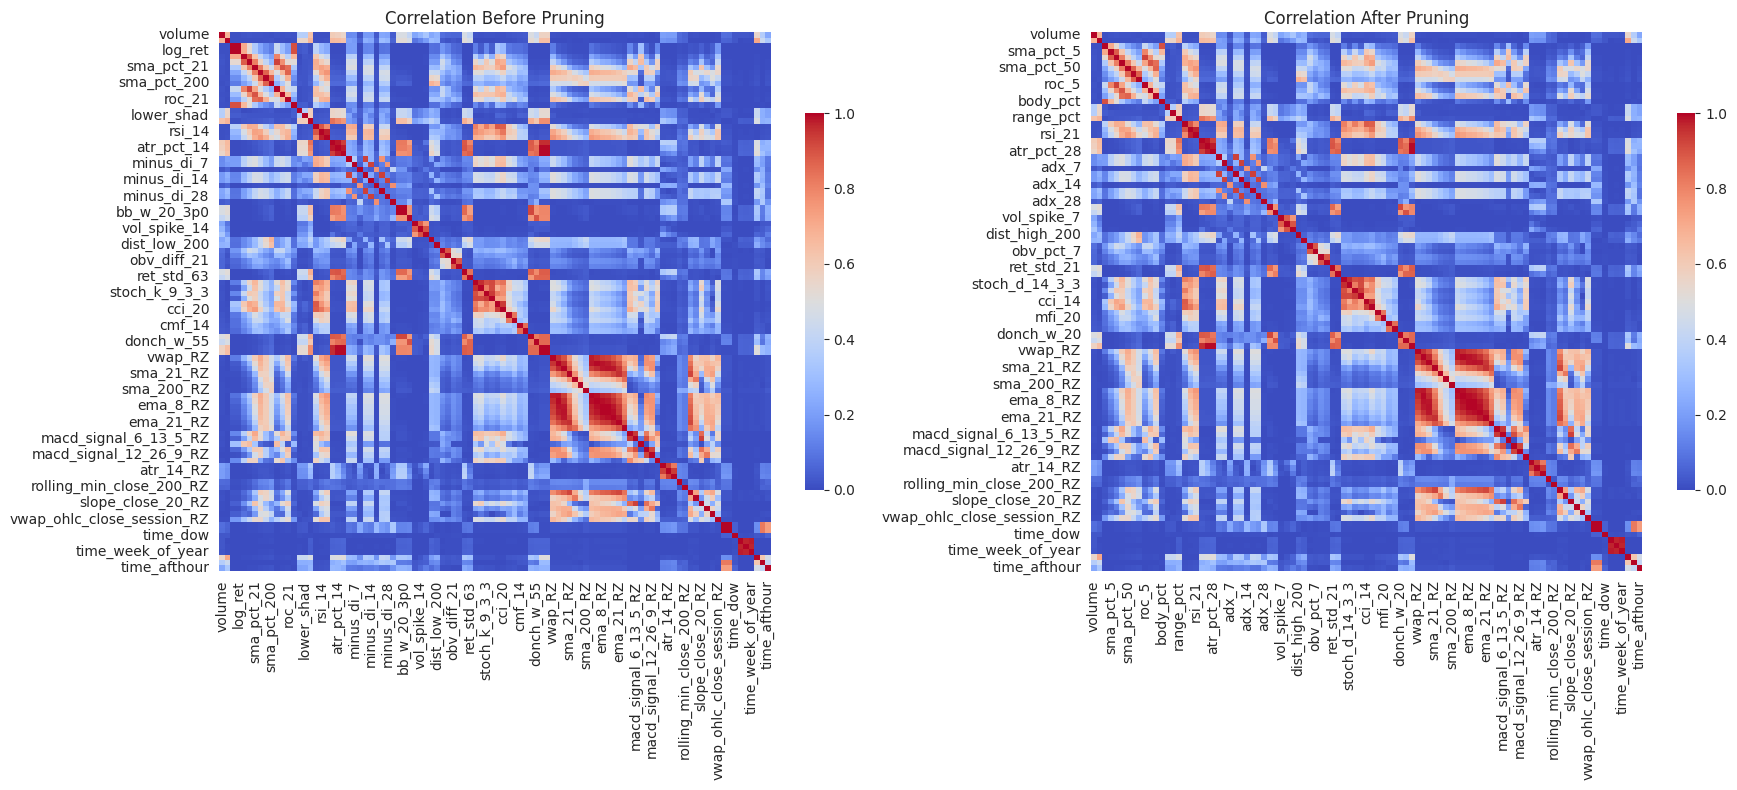

In [6]:
# importlib.reload(feats) ##### 

kept_final_feats, pruned_feats, corr_full, corr_pruned = feats.prune_features_by_variance_and_correlation(
    X_all=X_all,
    y=y,
    min_std=params.feats_min_std,
    max_corr=params.feats_max_corr,
)

# show heatmaps
plots.plot_correlation_before_after(corr_full, corr_pruned)

In [7]:
# build final feature DataFrame with signal and all features kept
cols = strategy_cols_tick_raw + params.signals_cols_tick + kept_final_feats
df_sign_allfeats = df_allfeats_sign[list(dict.fromkeys(cols)) ] # remove duplicates, keep order

params.to_csv_with_progress(df_sign_allfeats, params.sign_featall_csv)
df_sign_allfeats

Saving CSV: 100%|██████████| 1664205/1664205 [07:50<00:00, 3540.59rows/s, size=2.8GB]  


,atr_14_raw,adx_14_raw,rsi_6_raw,vwap_ohlc_close_session_raw,close_raw,targ_signal,signal_thresh,volume,trade_count,ret,sma_pct_5,sma_pct_9,sma_pct_21,sma_pct_50,sma_pct_100,sma_pct_200,roc_5,roc_10,roc_21,body_pct,upper_shad,lower_shad,range_pct,rsi_6,rsi_14,rsi_21,atr_pct_7,atr_pct_14,atr_pct_28,plus_di_7,minus_di_7,adx_7,plus_di_14,minus_di_14,adx_14,plus_di_28,minus_di_28,adx_28,bb_w_20_2p0,bb_w_50_2p0,vol_spike_7,vol_spike_14,vol_spike_28,dist_high_200,dist_low_200,obv_diff_7,obv_pct_7,obv_diff_21,obv_pct_21,ret_std_21,ret_std_63,stoch_k_14_3_3,stoch_d_14_3_3,stoch_k_9_3_3,stoch_d_9_3_3,cci_14,cci_20,mfi_14,mfi_20,cmf_14,cmf_20,donch_w_20,donch_w_55,kc_w_20_20_1.5,vwap_RZ,sma_5_RZ,sma_9_RZ,sma_21_RZ,sma_50_RZ,sma_100_RZ,sma_200_RZ,ema_3_RZ,ema_5_RZ,ema_8_RZ,ema_9_RZ,ema_13_RZ,ema_21_RZ,ema_50_RZ,macd_line_6_13_5_RZ,macd_signal_6_13_5_RZ,macd_diff_6_13_5_RZ,macd_line_12_26_9_RZ,macd_signal_12_26_9_RZ,macd_diff_12_26_9_RZ,atr_7_RZ,atr_14_RZ,atr_28_RZ,rolling_max_close_200_RZ,rolling_min_close_200_RZ,roll_vwap_20_RZ,roll_vwap_50_RZ,slope_close_20_RZ,slope_close_50_RZ,psar_RZ,vwap_ohlc_close_session_RZ,time_minute,time_hour,time_dow,time_month,time_day_of_year,time_week_of_year,time_in_sess,time_premark,time_afthour
2019-01-02 08:00:00,0.100663,31.744522,4.083626,38.500000,38.500,0.100676,0.121416,0.010662,0.008669,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,1.000000,1.000000,0.038787,0.000000,0.000000,1.000000,0.964481,0.539469,0.032218,1.000000,0.395127,0.022780,1.000000,0.283520,0.000000,1.000000,0.189077,1.000000,0.559765,0.890034,0.817293,0.824080,0.831573,0.202308,0.443526,0.442860,0.444367,0.427280,1.000000,1.000000,0.609587,0.789256,0.540496,0.720165,0.000000,0.000000,0.586220,0.722529,0.466633,0.301437,1.000000,1.000000,0.695324,0.000000,0.000000,0.000000,0.000000,0.364087,0.016681,0.497026,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.115155,0.000000,1.000000,1.000000,1.000000,0.624997,0.366896,0.000000,0.014201,0.000000,0.192576,0.906771,0.967893,0.270833,0.270833,0.785714,0.5,0.502740,0.500000,0.0,1.0,0.0
2019-01-02 08:01:00,0.093473,35.997314,4.083626,38.500000,38.500,0.121157,0.121416,0.000161,0.000255,0.500539,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502374,0.0000,0.000000,0.000000,0.038787,0.000000,0.000000,1.000000,0.895243,0.519885,0.032218,1.000000,0.471026,0.022780,1.000000,0.337179,0.000000,1.000000,0.231728,1.000000,0.787723,0.026108,0.030440,0.029487,0.831573,0.202308,0.443495,0.442825,0.444408,0.427337,1.000000,1.000000,0.460993,0.649890,0.460993,0.603830,0.035894,0.000000,0.550541,0.720794,0.513471,0.307323,1.000000,1.000000,0.661687,0.000000,0.000000,0.000000,0.000000,0.229507,0.000000,0.476747,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.624997,0.366897,0.000000,0.104137,0.000000,0.000000,0.865912,0.967893,0.271528,0.270833,0.785714,0.5,0.502740,0.500000,0.0,1.0,0.0
2019-01-02 08:02:00,0.086885,39.931785,4.083626,38.500000,38.500,0.145805,0.121416,0.000324,0.000255,0.500539,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.492905,0.0000,0.000000,0.009418,0.038787,0.000000,0.000000,1.000000,0.831810,0.501454,0.033467,0.999010,0.535676,0.023995,1.000000,0.386823,0.000000,1.000000,0.272747,1.000000,0.957824,0.040116,0.046070,0.042049,0.831573,0.202308,0.443452,0.442776,0.444399,0.427327,1.000000,1.000000,0.191489,0.420690,0.191489,0.397660,0.188276,0.076442,0.526600,0.717945,0.541053,0.310713,1.000000,1.000000,0.630139,0.000000,0.000000,0.000000,0.000000,0.108220,0.000000,0.455409,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.624997,0.366897,0.000000,0.099785,0.000000,0.000000,0.660679,0.964445,0.272222,0.270833,0.78

In [8]:
# importlib.reload(models_core) ########

train_loader, val_loader, test_loader, end_times_tr, end_times_val, end_times_te = models_core.model_core_pipeline(
    df              = df_sign_allfeats,
    train_batch     = params.hparams["TRAIN_BATCH"],
    train_workers   = params.hparams["TRAIN_WORKERS"],
    prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"],
    look_back       = params.hparams["LOOK_BACK"],
    features_cols   = kept_final_feats,
)

del df_all_features, df_allfeats_sign, df_sign_allfeats, end_times_tr, end_times_val, end_times_te
gc.collect()

Preparing days:   0%|          | 0/1766 [00:00<?, ?it/s]

N_total: 1612991 look_back: 30 F: 97
Estimated X_buf size: 18.78 GB — using RAM (in-memory) (thresh 56 GiB)


Writing days:   0%|          | 0/1766 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

40

In [9]:
# importlib.reload(feats)

# Save test_loader X_windows and y_windows to be reused for feature importance

X_path, y_path, meta_path = feats.extract_and_save_windows(test_loader, out_dir=params.models_folder, features=kept_final_feats)
X_path, y_path, meta_path

Extracting windows:   0%|          | 0/264 [00:00<?, ?it/s]

Copying HDF5→memmap:   0%|          | 0/239 [00:00<?, ?it/s]

(PosixPath('trainings/X_windows.dat'),
 PosixPath('trainings/y_windows.dat'),
 PosixPath('trainings/X_windows_meta.json'))

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:375: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Training sees 1248 unique trading days per epoch.

Model parameters: total=122,501, trainable=122,501

Using HyperParameters:
 {'USE_CONV': False, 'CONV_K': 3, 'CONV_DILATION': 1, 'CONV_CHANNELS': 64, 'USE_TCN': False, 'TCN_LAYERS': 1, 'TCN_KERNEL': 3, 'TCN_CHANNELS': 64, 'USE_SHORT_LSTM': False, 'SHORT_UNITS': 64, 'DROPOUT_SHORT': 0.1, 'USE_TRANSFORMER': True, 'TRANSFORMER_D_MODEL': 64, 'TRANSFORMER_LAYERS': 2, 'TRANSFORMER_HEADS': 4, 'TRANSFORMER_FF_MULT': 4, 'DROPOUT_TRANS': 0.03, 'USE_LONG_LSTM': False, 'LONG_UNITS': 64, 'DROPOUT_LONG': 0.1, 'FLATTEN_MODE': 'attn', 'PRED_HIDDEN': 96, 'ALPHA_SMOOTH': 0, 'WARMUP_STEPS': 3, 'USE_HUBER': False, 'HUBER_DELTA': 0.1, 'USE_DELTA': False, 'LAMBDA_DELTA': 0.1, 'MAX_EPOCHS': 90, 'EARLY_STOP_PATIENCE': 9, 'WEIGHT_DECAY': 2e-06, 'CLIPNORM': 2, 'ONECYCLE_MAX_LR': 0.0002, 'HEAD_LR_PCT': 1, 'ONECYCLE_DIV_FACTOR': 10, 'ONECYCLE_FINAL_DIV': 100, 'ONECYCLE_PCT_START': 0.1, 'ONECYCLE_STRATEGY': 'cos', 'TRAIN_BATCH': 16, 'VAL_BATCH': 1, 'TRAIN_WORKERS'

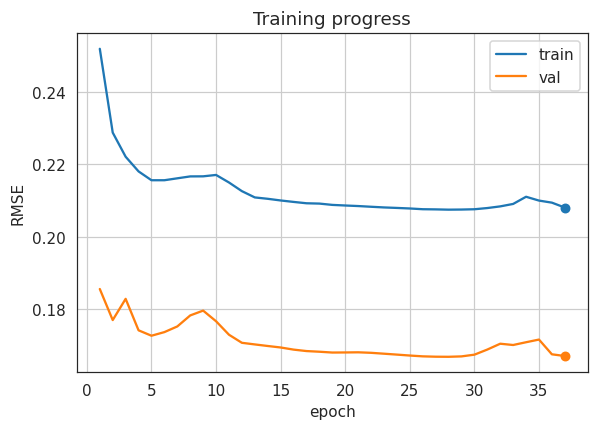

Epoch 1 ▶ Train:   0%|          | 0/78 [00:05<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

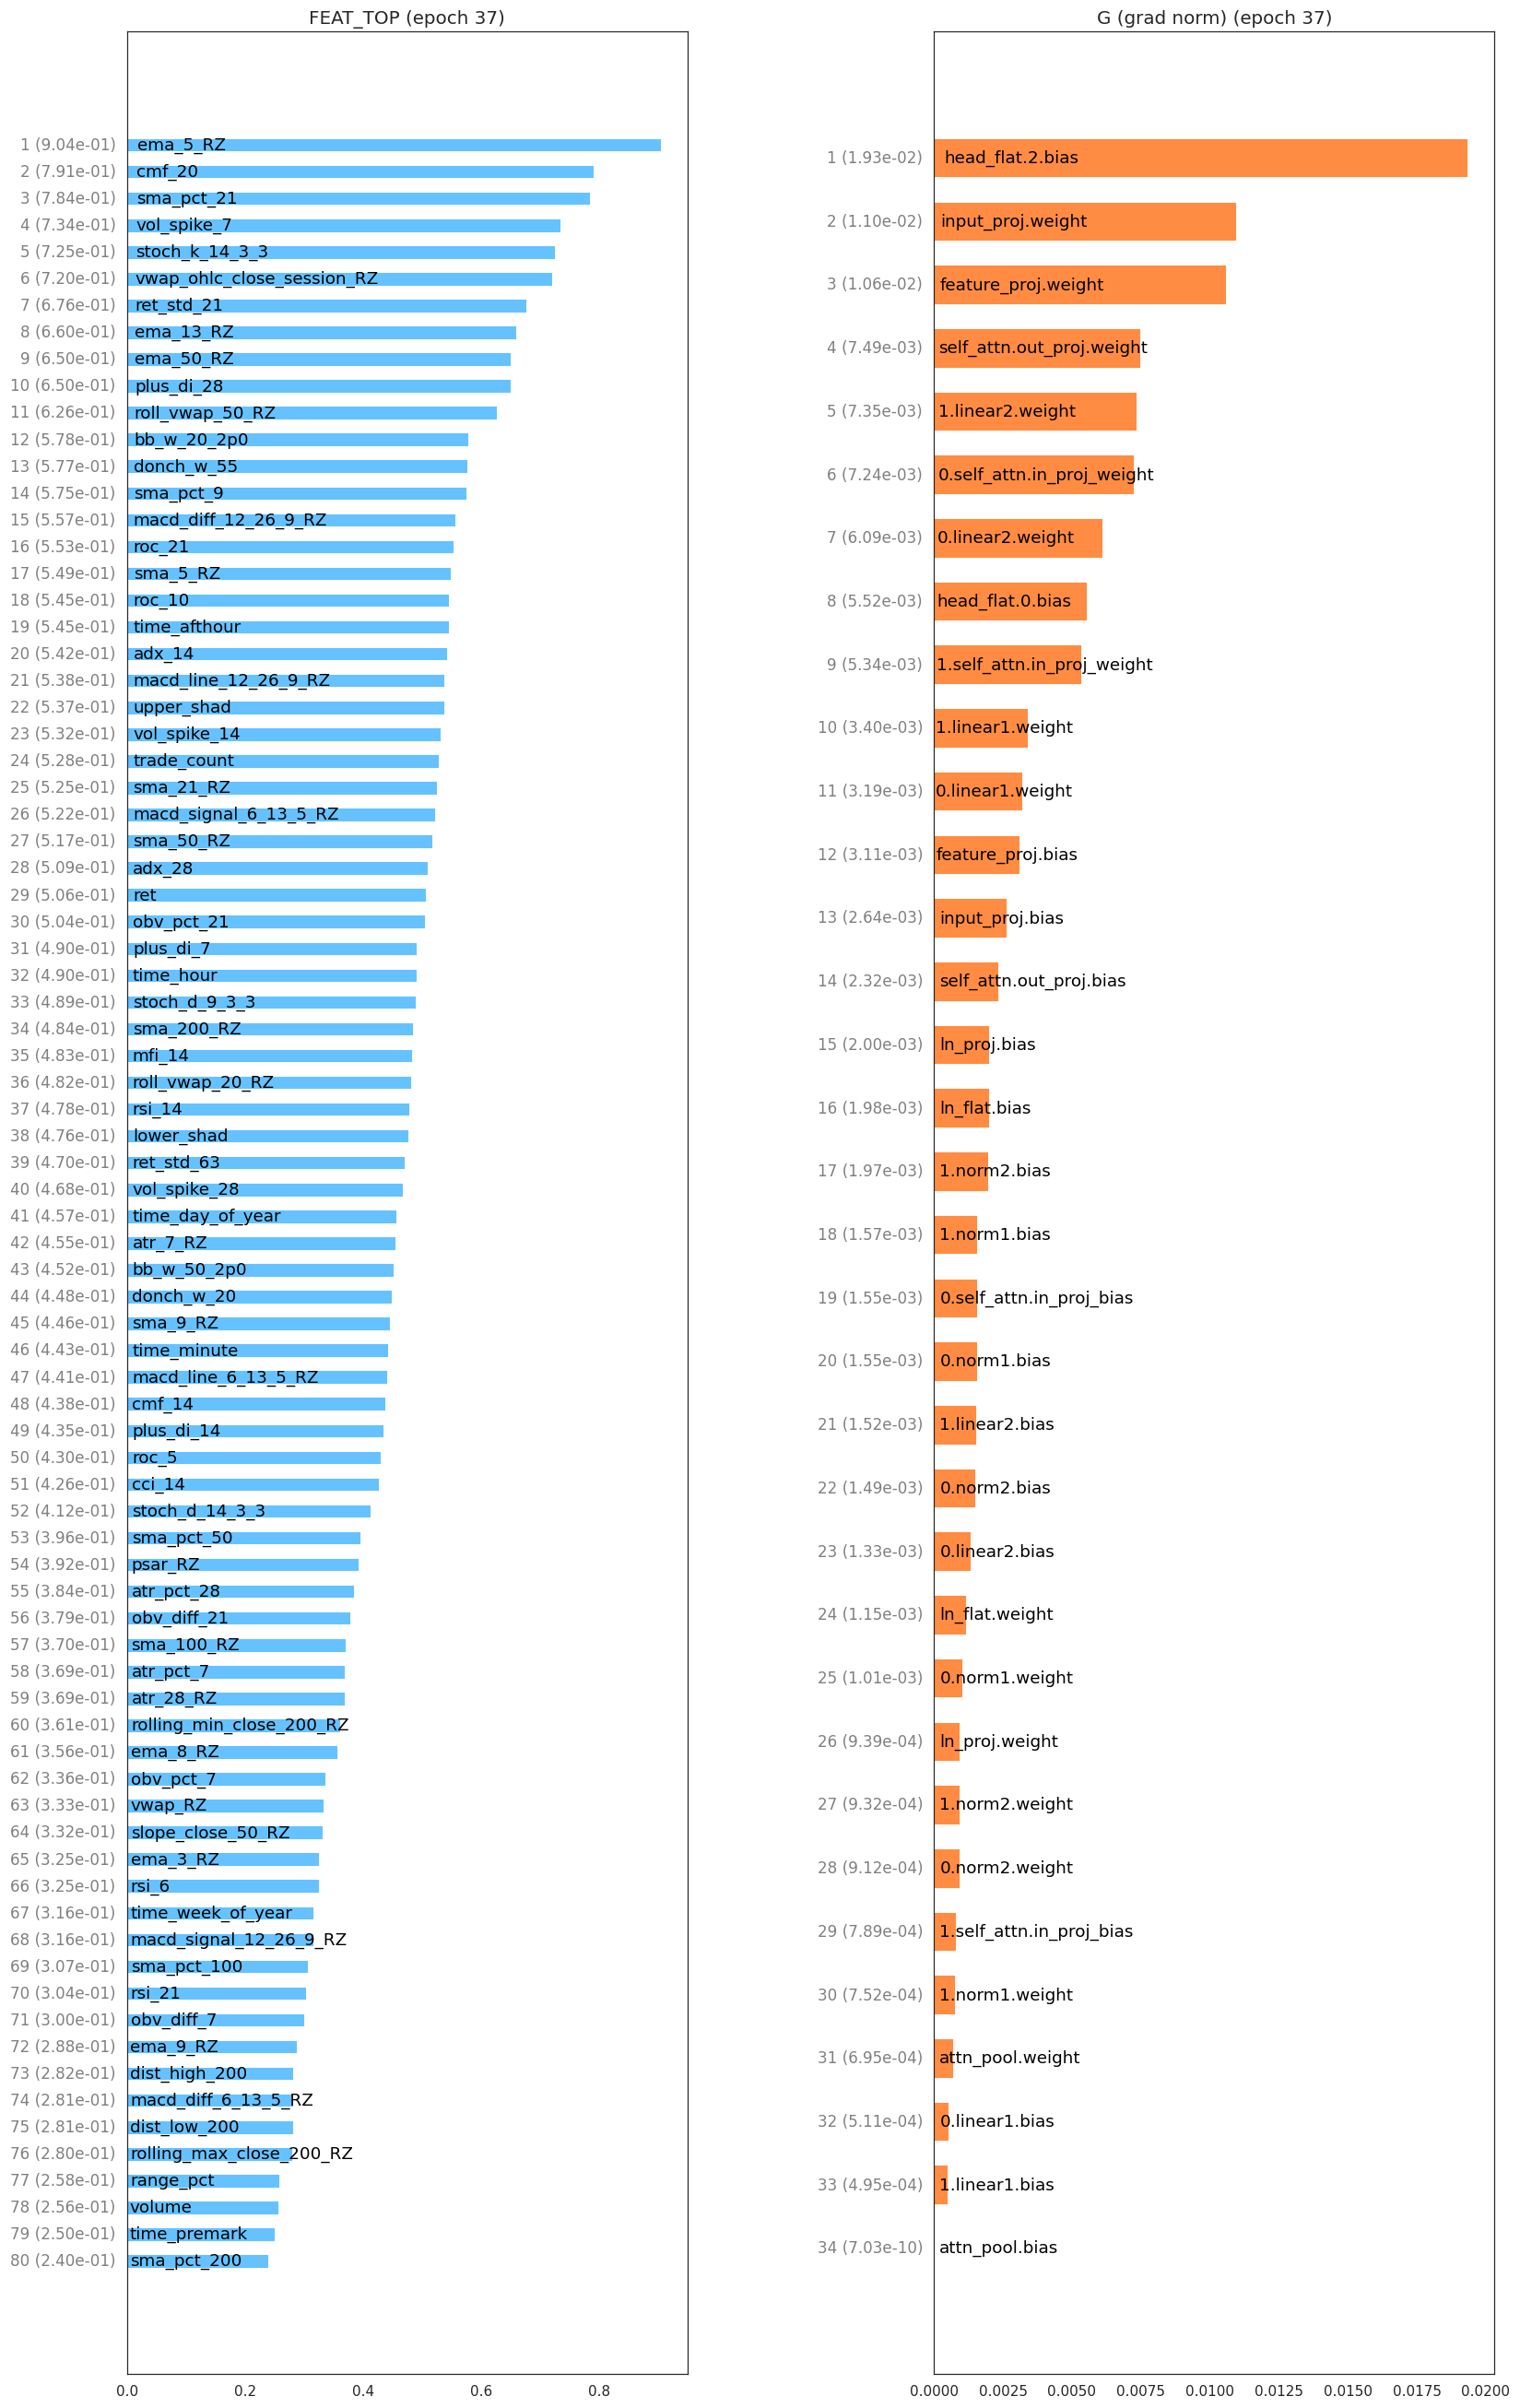

Epoch 01  TRAIN→ RMSE=0.25197, R²=-0.179 |  VALID→ RMSE=0.18559, R²=-0.015 |  lr=2.54e-05 |  loss=6.35610e-02 |  improved=True


Epoch 2 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 02  TRAIN→ RMSE=0.22881, R²=0.028 |  VALID→ RMSE=0.17700, R²=0.077 |  lr=4.11e-05 |  loss=5.23644e-02 |  improved=True


Epoch 3 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 03  TRAIN→ RMSE=0.22214, R²=0.083 |  VALID→ RMSE=0.18287, R²=0.014 |  lr=6.51e-05 |  loss=4.93525e-02 |  improved=False


Epoch 4 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 04  TRAIN→ RMSE=0.21809, R²=0.117 |  VALID→ RMSE=0.17417, R²=0.106 |  lr=9.45e-05 |  loss=4.75722e-02 |  improved=True


Epoch 5 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 05  TRAIN→ RMSE=0.21564, R²=0.136 |  VALID→ RMSE=0.17268, R²=0.121 |  lr=1.26e-04 |  loss=4.65106e-02 |  improved=True


Epoch 6 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 06  TRAIN→ RMSE=0.21564, R²=0.136 |  VALID→ RMSE=0.17368, R²=0.111 |  lr=1.55e-04 |  loss=4.65090e-02 |  improved=False


Epoch 7 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 07  TRAIN→ RMSE=0.21618, R²=0.132 |  VALID→ RMSE=0.17524, R²=0.095 |  lr=1.79e-04 |  loss=4.67389e-02 |  improved=False


Epoch 8 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 08  TRAIN→ RMSE=0.21670, R²=0.128 |  VALID→ RMSE=0.17829, R²=0.063 |  lr=1.95e-04 |  loss=4.69664e-02 |  improved=False


Epoch 9 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 09  TRAIN→ RMSE=0.21672, R²=0.128 |  VALID→ RMSE=0.17962, R²=0.049 |  lr=2.00e-04 |  loss=4.69769e-02 |  improved=False


Epoch 10 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 10  TRAIN→ RMSE=0.21711, R²=0.125 |  VALID→ RMSE=0.17668, R²=0.080 |  lr=2.00e-04 |  loss=4.71452e-02 |  improved=False


Epoch 11 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 11  TRAIN→ RMSE=0.21502, R²=0.141 |  VALID→ RMSE=0.17296, R²=0.118 |  lr=2.00e-04 |  loss=4.62443e-02 |  improved=False


Epoch 12 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 12  TRAIN→ RMSE=0.21263, R²=0.160 |  VALID→ RMSE=0.17072, R²=0.141 |  lr=1.99e-04 |  loss=4.52204e-02 |  improved=True


Epoch 13 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 13  TRAIN→ RMSE=0.21089, R²=0.174 |  VALID→ RMSE=0.17027, R²=0.146 |  lr=1.99e-04 |  loss=4.44843e-02 |  improved=True


Epoch 14 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 14  TRAIN→ RMSE=0.21052, R²=0.177 |  VALID→ RMSE=0.16984, R²=0.150 |  lr=1.98e-04 |  loss=4.43242e-02 |  improved=True


Epoch 15 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 15  TRAIN→ RMSE=0.21006, R²=0.180 |  VALID→ RMSE=0.16943, R²=0.154 |  lr=1.97e-04 |  loss=4.41307e-02 |  improved=True


Epoch 16 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 16  TRAIN→ RMSE=0.20965, R²=0.184 |  VALID→ RMSE=0.16884, R²=0.160 |  lr=1.96e-04 |  loss=4.39626e-02 |  improved=True


Epoch 17 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 17  TRAIN→ RMSE=0.20928, R²=0.187 |  VALID→ RMSE=0.16844, R²=0.164 |  lr=1.95e-04 |  loss=4.38057e-02 |  improved=True


Epoch 18 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 18  TRAIN→ RMSE=0.20919, R²=0.187 |  VALID→ RMSE=0.16826, R²=0.166 |  lr=1.94e-04 |  loss=4.37686e-02 |  improved=True


Epoch 19 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 19  TRAIN→ RMSE=0.20883, R²=0.190 |  VALID→ RMSE=0.16803, R²=0.168 |  lr=1.93e-04 |  loss=4.36181e-02 |  improved=True


Epoch 20 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 20  TRAIN→ RMSE=0.20866, R²=0.191 |  VALID→ RMSE=0.16805, R²=0.168 |  lr=1.91e-04 |  loss=4.35482e-02 |  improved=False


Epoch 21 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 21  TRAIN→ RMSE=0.20851, R²=0.192 |  VALID→ RMSE=0.16810, R²=0.167 |  lr=1.89e-04 |  loss=4.34852e-02 |  improved=False


Epoch 22 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 22  TRAIN→ RMSE=0.20831, R²=0.194 |  VALID→ RMSE=0.16796, R²=0.169 |  lr=1.88e-04 |  loss=4.34027e-02 |  improved=True


Epoch 23 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 23  TRAIN→ RMSE=0.20813, R²=0.195 |  VALID→ RMSE=0.16771, R²=0.171 |  lr=1.86e-04 |  loss=4.33252e-02 |  improved=True


Epoch 24 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 24  TRAIN→ RMSE=0.20799, R²=0.197 |  VALID→ RMSE=0.16746, R²=0.174 |  lr=1.84e-04 |  loss=4.32683e-02 |  improved=True


Epoch 25 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16720_chp.pth
Epoch 25  TRAIN→ RMSE=0.20784, R²=0.198 |  VALID→ RMSE=0.16720, R²=0.176 |  lr=1.81e-04 |  loss=4.32055e-02 |  improved=True


Epoch 26 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16698_chp.pth
Epoch 26  TRAIN→ RMSE=0.20764, R²=0.199 |  VALID→ RMSE=0.16698, R²=0.178 |  lr=1.79e-04 |  loss=4.31201e-02 |  improved=True


Epoch 27 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16688_chp.pth
Epoch 27  TRAIN→ RMSE=0.20759, R²=0.200 |  VALID→ RMSE=0.16688, R²=0.179 |  lr=1.77e-04 |  loss=4.31012e-02 |  improved=True


Epoch 28 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16686_chp.pth
Epoch 28  TRAIN→ RMSE=0.20751, R²=0.200 |  VALID→ RMSE=0.16686, R²=0.180 |  lr=1.74e-04 |  loss=4.30693e-02 |  improved=True


Epoch 29 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 29  TRAIN→ RMSE=0.20755, R²=0.200 |  VALID→ RMSE=0.16697, R²=0.178 |  lr=1.71e-04 |  loss=4.30829e-02 |  improved=False


Epoch 30 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 30  TRAIN→ RMSE=0.20763, R²=0.199 |  VALID→ RMSE=0.16744, R²=0.174 |  lr=1.69e-04 |  loss=4.31162e-02 |  improved=False


Epoch 31 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 31  TRAIN→ RMSE=0.20796, R²=0.197 |  VALID→ RMSE=0.16885, R²=0.160 |  lr=1.66e-04 |  loss=4.32543e-02 |  improved=False


Epoch 32 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 32  TRAIN→ RMSE=0.20842, R²=0.193 |  VALID→ RMSE=0.17047, R²=0.144 |  lr=1.63e-04 |  loss=4.34451e-02 |  improved=False


Epoch 33 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 33  TRAIN→ RMSE=0.20909, R²=0.188 |  VALID→ RMSE=0.17011, R²=0.147 |  lr=1.60e-04 |  loss=4.37279e-02 |  improved=False


Epoch 34 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 34  TRAIN→ RMSE=0.21108, R²=0.172 |  VALID→ RMSE=0.17088, R²=0.139 |  lr=1.57e-04 |  loss=4.45622e-02 |  improved=False


Epoch 35 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 35  TRAIN→ RMSE=0.21002, R²=0.181 |  VALID→ RMSE=0.17162, R²=0.132 |  lr=1.53e-04 |  loss=4.41156e-02 |  improved=False


Epoch 36 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 36  TRAIN→ RMSE=0.20945, R²=0.185 |  VALID→ RMSE=0.16754, R²=0.173 |  lr=1.50e-04 |  loss=4.38789e-02 |  improved=False


Epoch 37 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 37  TRAIN→ RMSE=0.20810, R²=0.196 |  VALID→ RMSE=0.16707, R²=0.177 |  lr=1.47e-04 |  loss=4.33123e-02 |  improved=False
✅ Final‐best model saved: AAPL_0.16686_all.pth


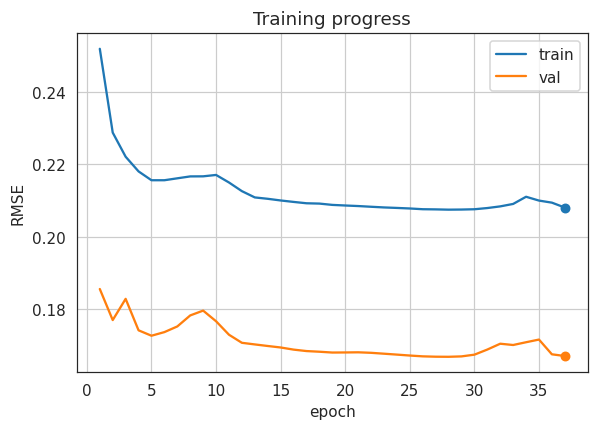

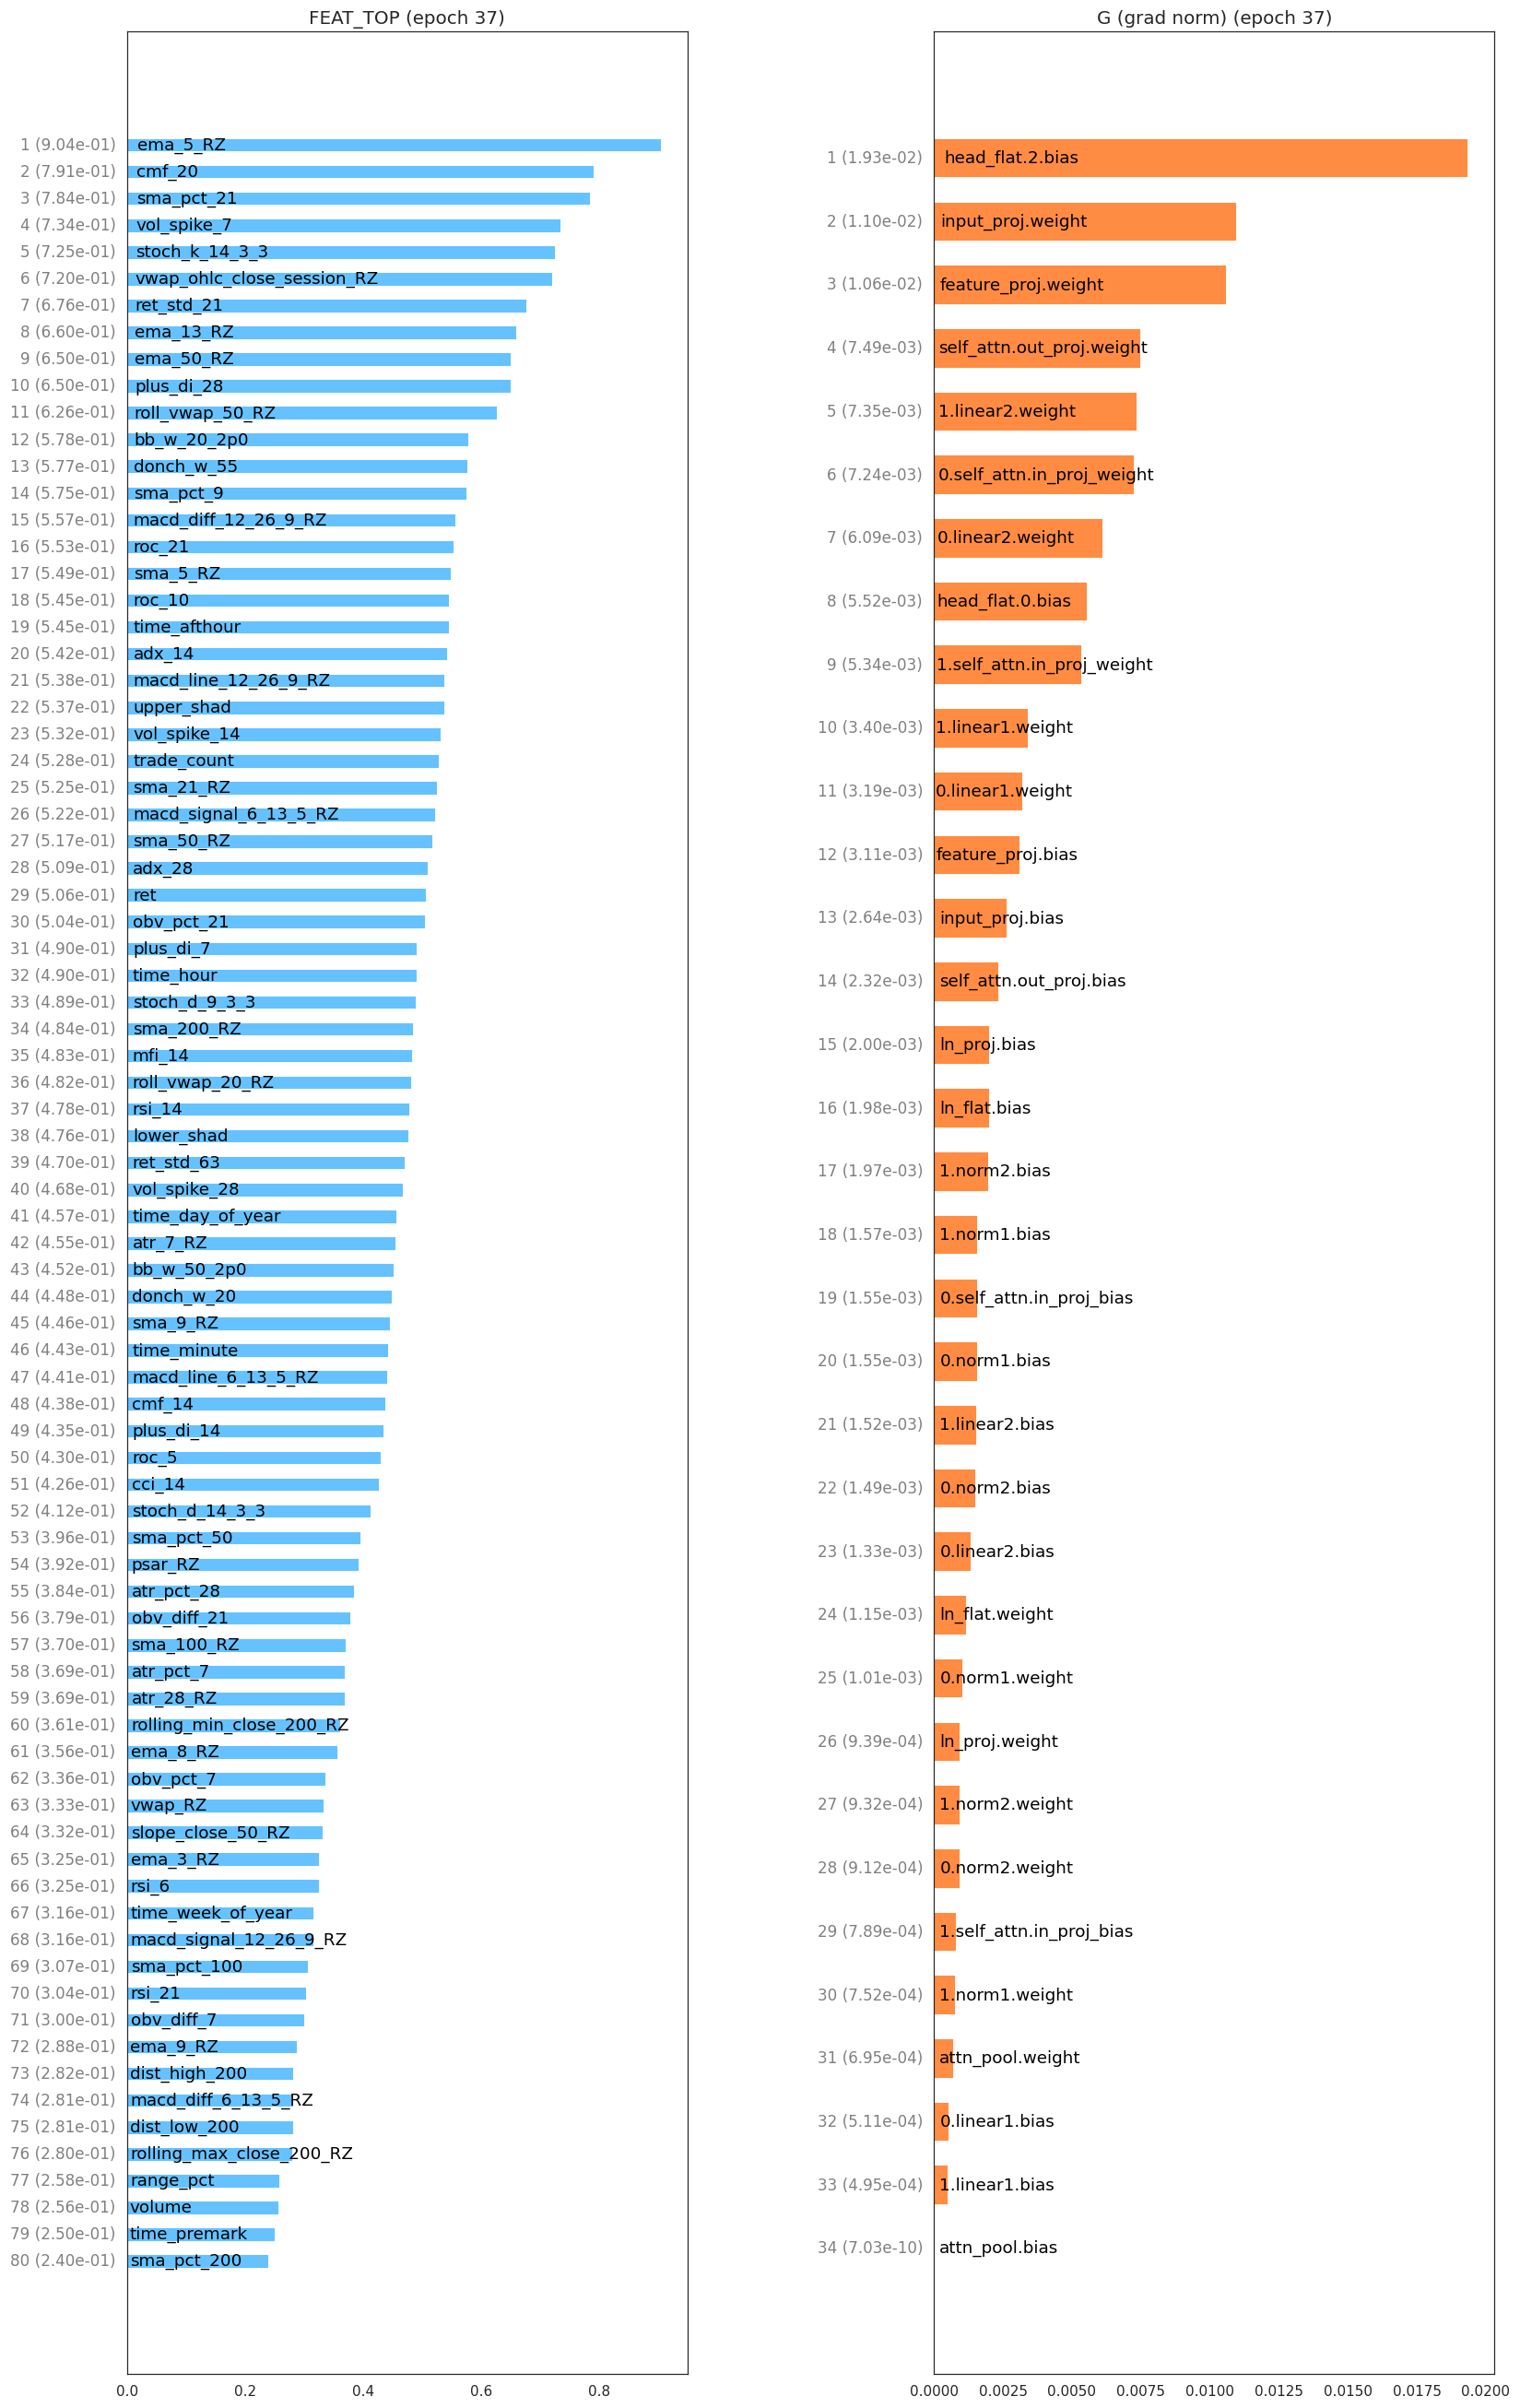

In [10]:
# importlib.reload(models_core)

#################### MODEL TRAINING #####################

model = models_custom.ModelClass(
    n_feats             = len(kept_final_feats),
    short_units         = params.hparams["SHORT_UNITS"],
    long_units          = params.hparams["LONG_UNITS"],
    transformer_d_model = params.hparams["TRANSFORMER_D_MODEL"],
    transformer_layers  = params.hparams["TRANSFORMER_LAYERS"],
    dropout_short       = params.hparams["DROPOUT_SHORT"],
    dropout_long        = params.hparams["DROPOUT_LONG"],
    dropout_trans       = params.hparams["DROPOUT_TRANS"],
    pred_hidden         = params.hparams["PRED_HIDDEN"],
    look_back           = params.hparams["LOOK_BACK"],

    # Gating flags
    use_conv            = params.hparams["USE_CONV"],
    use_tcn             = params.hparams["USE_TCN"],
    use_short_lstm      = params.hparams["USE_SHORT_LSTM"],
    use_transformer     = params.hparams["USE_TRANSFORMER"],
    use_long_lstm       = params.hparams["USE_LONG_LSTM"],
    use_delta           = params.hparams["USE_DELTA"],
    flatten_mode        = params.hparams["FLATTEN_MODE"]
)

model.feature_names = kept_final_feats # for logging
model.to(params.device)  
    
optimizer = AdamW(
  model.parameters(),
  lr           = params.hparams["ONECYCLE_MAX_LR"],
  weight_decay = params.hparams["WEIGHT_DECAY"]
)

batches_per_epoch = len(train_loader)
total_steps = batches_per_epoch * params.hparams["MAX_EPOCHS"]

scheduler = OneCycleLR(
  optimizer,
  max_lr           = params.hparams["ONECYCLE_MAX_LR"],
  total_steps      = total_steps,
  pct_start        = params.hparams["ONECYCLE_PCT_START"],
  div_factor       = params.hparams["ONECYCLE_DIV_FACTOR"],
  final_div_factor = params.hparams["ONECYCLE_FINAL_DIV"],
  anneal_strategy  = params.hparams["ONECYCLE_STRATEGY"],
)
optimizer.scheduler = scheduler # necessary to log sched_field

if getattr(scheduler, "total_steps", None) != total_steps:
    raise RuntimeError(f"Scheduler total_steps mismatch: scheduler={getattr(scheduler,'total_steps',None)} expected={total_steps}")

n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: total={total_params:,}, trainable={trainable_params:,}\n")
print('Using HyperParameters:\n', params.hparams)
print('\ntorch.cuda.is_available', torch.cuda.is_available())

# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = models_custom.model_training_loop(
    model               = model,
    optimizer           = optimizer,
    scheduler           = scheduler,
    scaler              = GradScaler(),
    train_loader        = train_loader,
    val_loader          = val_loader,
    all_features        = True
)
